In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Function to load and transform an image
def get_image(path, img_transform, size = (300,300)):
    
    image = Image.open(path) # Open the image file
    
    image = image.resize(size, Image.LANCZOS) # Resize the image
    
    image = img_transform(image).unsqueeze(0) # Apply the transformation and add a batch dimension
    
    return image.to(device) # Move the image to the device (GPU or CPU)

# Function to compute the Gram matrix of a tensor
def get_gram(m):
    _, c, h, w = m.size() # Get the dimensions of the tensor
    
    m = m.view(c, h * w)  # Reshape the tensor so it's two-dimensional
    
    m = torch.mm(m, m.t()) # Compute the Gram matrix by multiplying the tensor with its transpose 
    
    return m

# Function to denormalize and prepare an image for display
def denormalize_img(inp):
    
    # Convert the tensor to a numpy array and rearrange dimensions for display:
    inp = inp.numpy().transpose((1, 2, 0)) 
    
    # Define the mean and standard deviation used for normalization:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Apply the reverse of the normalization transformation:
    inp = std * inp + mean
    
    # Clip values to be between 0 and 1:
    inp = np.clip(inp, 0, 1)
    
    return inp

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        # Define the layers of the VGG16 model from which features will be extracted:
        self.selected_layers = [3, 8, 15, 22]
        
        # Load the pre-trained VGG16 model and use its feature extraction part:
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        
        # List to store the outputs of selected layers:
        layer_features = []
        
        # Iterate through the layers of the VGG model:
        for layer_number, layer in self.vgg._modules.items():
            # Pass the input through each layer:
            x = layer(x)
            
            # If the layer is one of the selected layers, save its output:
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
                
        return layer_features

In [4]:
# Define the image transformation: convert to tensor and normalize:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

# Load and transform the content and style images:
content_img = get_image('content.jpg', img_transform)
style_img = get_image('style.jpg', img_transform)

# Initialize the generated image as a copy of the content image:
generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))

# Enable gradient computation for the generated image:
generated_img.requires_grad = True

# Define the optimizer for updating the generated image:
optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])

# Initialize the feature extractor and move it to the appropriate device:
encoder = FeatureExtractor().to(device)

# Freeze the parameters of the encoder to prevent them from being updated:
for p in encoder.parameters():
    p.requires_grad = False

C:\Users\Chang.LAPTOP-KLP71L1N\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chang.LAPTOP-KLP71L1N\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Set the weights for content and style losses:
content_weight = 1
style_weight = 100

# Main loop for style transfer:
for epoch in range(500):
    
    # Extract features of content, style, and generated images:
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    # Compute content loss as the mean squared error between features of content and generated images:
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  
    
    # Initialize style loss:
    style_loss = 0
    
    for gf, sf in zip(generated_features, style_features):
        
        # Calculate the size of each feature map
        _, c, h, w = gf.size()
        
        # Compute Gram matrices for generated and style features:
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        
        # Compute style loss as mean squared error between Gram matrices, normalized by the size of the feature maps:
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) 
    
    # Total loss is a weighted sum of content and style losses:
    loss = content_weight * content_loss + style_weight * style_loss 
    
    # Backpropagation:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print losses every 10 epochs:
    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 539.8494
Epoch [10]	Content Loss: 1.0469	Style Loss: 440.3793
Epoch [20]	Content Loss: 1.4670	Style Loss: 369.8584
Epoch [30]	Content Loss: 1.6507	Style Loss: 318.7932
Epoch [40]	Content Loss: 1.7619	Style Loss: 280.2537
Epoch [50]	Content Loss: 1.8417	Style Loss: 249.7480
Epoch [60]	Content Loss: 1.9038	Style Loss: 224.9597
Epoch [70]	Content Loss: 1.9492	Style Loss: 204.3750
Epoch [80]	Content Loss: 1.9873	Style Loss: 186.9929
Epoch [90]	Content Loss: 2.0231	Style Loss: 172.1438
Epoch [100]	Content Loss: 2.0598	Style Loss: 159.4114
Epoch [110]	Content Loss: 2.0952	Style Loss: 148.3744
Epoch [120]	Content Loss: 2.1270	Style Loss: 138.7038
Epoch [130]	Content Loss: 2.1548	Style Loss: 130.1758
Epoch [140]	Content Loss: 2.1807	Style Loss: 122.6007
Epoch [150]	Content Loss: 2.2044	Style Loss: 115.8336
Epoch [160]	Content Loss: 2.2254	Style Loss: 109.7533
Epoch [170]	Content Loss: 2.2436	Style Loss: 104.2583
Epoch [180]	Content Loss: 2.2595	Style 

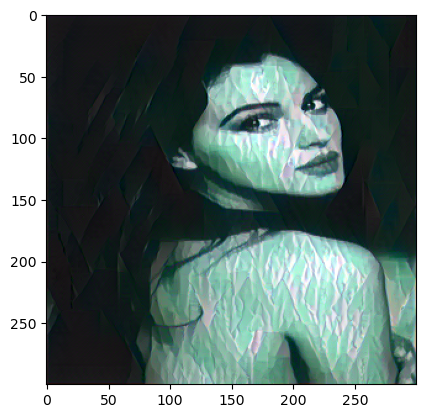

In [6]:
# Detach the generated image from the current computational graph, move it to CPU, and remove the batch dimension
inp = generated_img.detach().cpu().squeeze()

# Denormalize the image to convert it back to the standard image format
inp = denormalize_img(inp)

# Display the image using matplotlib
plt.imshow(inp)